# Physical Properties of Rivers: Querying Metadata and Discharge Data

This lesson was adapted from educational material written by [Dr. Kateri Salk](https://www.hydroshare.org/user/4912/) for her Fall 2019 Hydrologic Data Analysis course at Duke University. This is the second part of a two-part exercise focusing on the physical properties of rivers. 

## Introduction

Rivers are bodies of freshwater flowing from higher elevations to lower elevations due to the force of gravity. One of the most important physical characteristics of a stream or river is **discharge**, the volume of water moving through the river or stream over a given amount of time. Discharge can be measured directly by measuring the velocity of flow in several spots in a stream and multiplying the flow velocity over the cross-sectional area of the stream. However, this method is effort-intensive. This exercise will demonstrate how to approximate discharge by developing a **rating curve** for a stream at a given sampling point.You will also learn to query metadata from and compare discharge patterns in climatically different regions of the United States. 

## Learning Objectives 

After successfully completing this exercise, you will be able to:

1. Execute queries to pull a variety of National Water Information System (NWIS) and Water Quality Portal (WQP) data into R.
2. Analyze seasonal and interannual characteristics of stream discharge and compare discharge patterns in different regions of the United States 

## Requirements to Complete Lesson 

### Packages 
This lesson requires the installation of the following R packages to run the provided script:
- `tidyverse`- Version 1.3.0. A collection of R packages designed for data science. 
- `lubridate`- Version 1.7.9. Functions for working with dates/times. 
- `ggplot2`- Version 3.3.3. Creates elegant data visualisations using the Grammar of Graphics.
- `scales`- Version 1.1.1. Graphical scales provide methods for automatically determining breaks and labels for axes and legends.
- `repr`- Version 1.1.0. String and binary representations of objects for several formats/mime types.
- `cowplot`- Version 1.1.1. Provides various features that help with creating publication-quality figures with 'ggplot2', such as a set of themes, functions to align plots and arrange them into complex compound figures, and functions that make it easy to annotate plots and or mix plots with images.
- `dataRetrieval`- Version 2.7.6. Retrieval Functions for USGS and EPA Hydrologic and Water Quality Data.

### Data and Code 

This lesson will import metadata and discharge data using the `dataRetrieval` package. The package was created to make querying and downloading hydrologic data from the USGS National Water Information System (NWIS) and the multi-agency database, Water Quality Portal (WQP). NWIS only contains data collected by or for the USGS. It should be noted that the databases are not static as data is constantly being added.  For more in-depth information on the `dataRetrieval` package, please visit 
https://cran.r-project.org/web/packages/dataRetrieval/vignettes/dataRetrieval.html. 

This exercise will analyze data from the following rivers/streams: 

* Haw River in North Carolina
* Verde River in Arizona 
* Bitterroot River in Montana
* Sauk River in Minnesota 
* Nehalem River in Oregon

The code provided in this resource was developed using R version 3.6.1. 

### Set Working Directory 

In R, the working directory is the directory where R starts when looking for any file to open (as directed by a file path) and where it saves any output. This lesson assumes that you have set your working directory to the folder location of the downloaded and unzipped data subsets.

### Load Packages and set ggplot theme

In [27]:
options(warn=-1)

library(tidyverse)
library(lubridate)
library(ggplot2)
library(scales)
library(cowplot)
library(dataRetrieval) 

theme_set(theme_gray()) 

## Create a Rating Curve 

To develop a rating curve, a series of measurements of discharge and stream stage must be made together to develop a mathematical relationship. Then, subsequent discharge measurements can be calculated from a measurement of stream stage, measured by a gage that takes readings remotely. 

### `readNWISdv`
Use the `readNWISdv` function to import daily discharge data from NWIS web service. You can access the complete list of NWIS parameter codes here: https://nwis.waterdata.usgs.gov/nwis/pmcodes. 

The following are key parameter codes that serve as arguments for the `readNWISdv` function:

**siteNumbers**: character USGS site number. This is usually an 8 digit number. Multiple sites can be requested with a character vector.

**parameterCd**: character of USGS parameter code(s). This is usually an 5 digit number.

**startDate**: character starting date for data retrieval in the form YYYY-MM-DD.
Default is "" which indicates retrieval for the earliest possible record. Date arguments are always specified in local time.

**endDate**: character ending date for data retrieval in the form YYYY-MM-DD.
Default is "" which indicates retrieval for the latest possible record. Date arguments are always specified in local time.

**statCd**: character USGS statistic code. This is usually 5 digits. Daily mean (00003) is the default.

### Create a data frame extracting Discharge and Gage Height data from the USGS Haw River Site in North Carolina

In [28]:
EnoDischarge.ratingcurve <- readNWISdv(siteNumbers = "02096500",
                     parameterCd = c("00060", "00065"),
                     startDate = "2009-08-01",
                     endDate = "2019-07-31")

EnoDischarge.ratingcurve<-drop_na(EnoDischarge.ratingcurve) #remove observations without data

#### Rename columns

In [29]:
names(EnoDischarge.ratingcurve)[4:7] <- c("Discharge", "D.Approval.Code",
                                          "Gage.Height", "GH.Approval.Code")

head(EnoDischarge.ratingcurve)

,agency_cd,site_no,Date,Discharge,D.Approval.Code,Gage.Height,GH.Approval.Code
,<chr>,<chr>,<date>,<dbl>,<chr>,<dbl>,<chr>
1,USGS,02096500,2009-08-01,186,A,2.13,A
2,USGS,02096500,2009-08-02,129,A,1.89,A
3,USGS,02096500,2009-08-03,123,A,1.85,A
4,USGS,02096500,2009-08-04,118,A,1.84,A
5,USGS,02096500,2009-08-05,84,A,1.66,A
6,USGS,02096500,2009-08-06,112,A,1.77,A


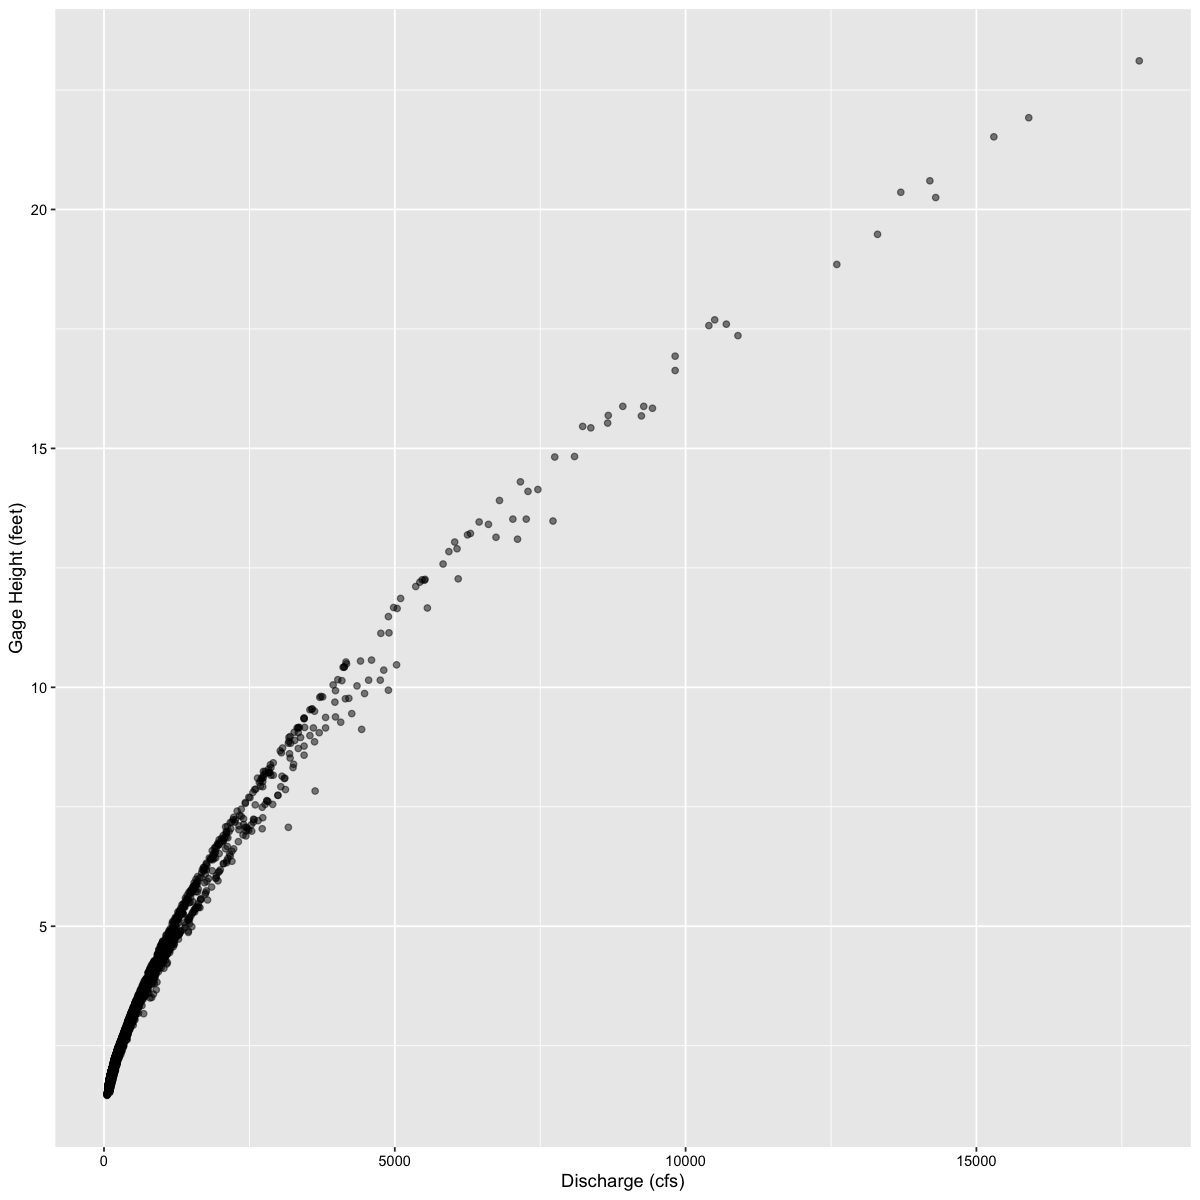

In [30]:
DvsGHplot <-
  ggplot(EnoDischarge.ratingcurve, aes(x = Discharge, y = Gage.Height)) +
  geom_point(alpha = 0.5) +
xlab("Discharge (cfs)") +
ylab("Gage Height (feet)")+
theme(axis.text.x = element_text(color = "black"), axis.text.y = element_text(color = "black"))
     
print(DvsGHplot)

## Import Water Quality Portal Metadata into R

## `whatNWISdata`

`whatNWISdata` allows us to access metadata about a site, including what variables have been monitored at that site, start and end dates, and the number of samples for a given variable allows us to access metadata about a site, including what variables have been monitored at that site, start and end dates, and the number of samples for a given variable. For more information on the `whatNWISdata` function, please visit https://rdrr.io/cran/dataRetrieval/man/whatNWISdata.html.

### Create a data frame extracting Metadata from the Haw River in North Carolina

In [31]:
HawSummary <- whatNWISdata(siteNumbers = "02096500") ##whatNWISdata allows us to access metadata about a site
print(HawSummary)

   agency_cd  site_no                 station_nm site_tp_cd dec_lat_va
1       USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
2       USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
3       USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
4       USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
5       USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
6       USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
7       USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
8       USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
9       USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
10      USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
11      USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
12      USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
13      USGS 02096500 HAW RIVER AT HAW RIVER, NC         ST   36.08722
14    

Scroll down through the summary and notice the "**parm_cd**" and "**stat_cd**" columns. These correspond to the USGS Parameter Codes and USGS Statistics Codes, respectively. The complete list of parameter codes  can be found here: https://nwis.waterdata.usgs.gov/nwis/pmcodes/. The complete list of statistics codes can be found here: https://help.waterdata.usgs.gov/stat_code.

### Create a data frame extracting Metadata from the Verde River in Arizona

In [32]:
VerdeSummary <- whatNWISdata(siteNumbers = "09504000")
print(VerdeSummary)

    agency_cd  site_no                     station_nm site_tp_cd dec_lat_va
1        USGS 09504000 VERDE RIVER NEAR CLARKDALE, AZ         ST   34.85224
2        USGS 09504000 VERDE RIVER NEAR CLARKDALE, AZ         ST   34.85224
3        USGS 09504000 VERDE RIVER NEAR CLARKDALE, AZ         ST   34.85224
4        USGS 09504000 VERDE RIVER NEAR CLARKDALE, AZ         ST   34.85224
5        USGS 09504000 VERDE RIVER NEAR CLARKDALE, AZ         ST   34.85224
6        USGS 09504000 VERDE RIVER NEAR CLARKDALE, AZ         ST   34.85224
7        USGS 09504000 VERDE RIVER NEAR CLARKDALE, AZ         ST   34.85224
8        USGS 09504000 VERDE RIVER NEAR CLARKDALE, AZ         ST   34.85224
9        USGS 09504000 VERDE RIVER NEAR CLARKDALE, AZ         ST   34.85224
10       USGS 09504000 VERDE RIVER NEAR CLARKDALE, AZ         ST   34.85224
11       USGS 09504000 VERDE RIVER NEAR CLARKDALE, AZ         ST   34.85224
12       USGS 09504000 VERDE RIVER NEAR CLARKDALE, AZ         ST   34.85224
13       USG

### Create a data frame extracting Metadata from the Bitterroot River in Montana

In [33]:
BitterrootSummary <- whatNWISdata(siteNumbers = "12344000")
print(BitterrootSummary)

    agency_cd  site_no                     station_nm site_tp_cd dec_lat_va
1        USGS 12344000 Bitterroot River near Darby MT         ST   45.97205
2        USGS 12344000 Bitterroot River near Darby MT         ST   45.97205
3        USGS 12344000 Bitterroot River near Darby MT         ST   45.97205
4        USGS 12344000 Bitterroot River near Darby MT         ST   45.97205
5        USGS 12344000 Bitterroot River near Darby MT         ST   45.97205
6        USGS 12344000 Bitterroot River near Darby MT         ST   45.97205
7        USGS 12344000 Bitterroot River near Darby MT         ST   45.97205
8        USGS 12344000 Bitterroot River near Darby MT         ST   45.97205
9        USGS 12344000 Bitterroot River near Darby MT         ST   45.97205
10       USGS 12344000 Bitterroot River near Darby MT         ST   45.97205
11       USGS 12344000 Bitterroot River near Darby MT         ST   45.97205
12       USGS 12344000 Bitterroot River near Darby MT         ST   45.97205
13       USG

### Create a data frame extracting Metadata from the Nehalem River in Minnesota

In [34]:
SaukSummary <- whatNWISdata(siteNumbers = "05270500")
print(SaukSummary)

    agency_cd  site_no                    station_nm site_tp_cd dec_lat_va
1        USGS 05270500 SAUK RIVER NEAR ST. CLOUD, MN         ST   45.55969
2        USGS 05270500 SAUK RIVER NEAR ST. CLOUD, MN         ST   45.55969
3        USGS 05270500 SAUK RIVER NEAR ST. CLOUD, MN         ST   45.55969
4        USGS 05270500 SAUK RIVER NEAR ST. CLOUD, MN         ST   45.55969
5        USGS 05270500 SAUK RIVER NEAR ST. CLOUD, MN         ST   45.55969
6        USGS 05270500 SAUK RIVER NEAR ST. CLOUD, MN         ST   45.55969
7        USGS 05270500 SAUK RIVER NEAR ST. CLOUD, MN         ST   45.55969
8        USGS 05270500 SAUK RIVER NEAR ST. CLOUD, MN         ST   45.55969
9        USGS 05270500 SAUK RIVER NEAR ST. CLOUD, MN         ST   45.55969
10       USGS 05270500 SAUK RIVER NEAR ST. CLOUD, MN         ST   45.55969
11       USGS 05270500 SAUK RIVER NEAR ST. CLOUD, MN         ST   45.55969
12       USGS 05270500 SAUK RIVER NEAR ST. CLOUD, MN         ST   45.55969
13       USGS 05270500 SA

### Create a dataframe extracting Metadata from the Nehalem River in Oregon

In [35]:
NehalemSummary <- whatNWISdata(siteNumbers = "14299800")
print(head(NehalemSummary)) #for brevity

  agency_cd  site_no                      station_nm site_tp_cd dec_lat_va
1      USGS 14299800 NEHALEM RIVER NEAR VERNONIA, OR         ST   45.80706
2      USGS 14299800 NEHALEM RIVER NEAR VERNONIA, OR         ST   45.80706
3      USGS 14299800 NEHALEM RIVER NEAR VERNONIA, OR         ST   45.80706
4      USGS 14299800 NEHALEM RIVER NEAR VERNONIA, OR         ST   45.80706
5      USGS 14299800 NEHALEM RIVER NEAR VERNONIA, OR         ST   45.80706
6      USGS 14299800 NEHALEM RIVER NEAR VERNONIA, OR         ST   45.80706
  dec_long_va coord_acy_cd dec_coord_datum_cd alt_va alt_acy_va alt_datum_cd
1   -123.2832            S              NAD83    640         10       NGVD29
2   -123.2832            S              NAD83    640         10       NGVD29
3   -123.2832            S              NAD83    640         10       NGVD29
4   -123.2832            S              NAD83    640         10       NGVD29
5   -123.2832            S              NAD83    640         10       NGVD29
6   -123.2832

What data are available from the sites? Pay particular attention to the parameter codes and statistic codes.

>

What is the period of record for mean daily discharge at each of these sites?

> Eno River: 

> Verde River: 

> Bitterroot River: 

> Sauk River: 

> Nehalem River: 


## Import Discharge Data from all of the sites using `readNWISdv` 
For the purposes of this exercise, we will use a ten year period of record. 

#### Haw Discharge

In [36]:
HawDischarge <- readNWISdv(siteNumbers = "02096500",
                     parameterCd = "00060", # discharge (ft3/s)
                     startDate = "2010-09-01",
                     endDate = "2020-12-31")

#### Verde Discharge 

In [37]:
VerdeDischarge <- readNWISdv(siteNumbers = "09504000",
                     parameterCd = "00060", # discharge (ft3/s)
                     startDate = "2010-09-01",
                     endDate = "2020-12-31")

#### Bitterroot Discharge

In [38]:
BitterrootDischarge <- readNWISdv(siteNumbers = "12344000",
                     parameterCd = "00060", # discharge (ft3/s)
                     startDate = "2010-09-01",
                     endDate = "2020-12-31")

#### Sauk Discharge 

In [39]:
SaukDischarge <- readNWISdv(siteNumbers = "05270500",
                     parameterCd = "00060", # discharge (ft3/s)
                     startDate = "2010-09-01",
                     endDate = "2020-12-31")

#### Nehalem Discharge 

In [40]:
NehalemDischarge <- readNWISdv(siteNumbers = "14299800",
                     parameterCd = "00060", # discharge (ft3/s)
                     startDate = "2010-09-01",
                     endDate = "2020-12-31")

### Rename Discharge and Approval Code Columns of all Data Frames

In [41]:
names(HawDischarge)[4:5] <- c("Haw.Discharge", "Haw.Approval.Code")
names(VerdeDischarge)[4:5] <- c("Verde.Discharge", "Verde.Approval.Code")
names(BitterrootDischarge)[4:5] <- c("Bitterroot.Discharge", "Bitterroot.Approval.Code")
names(SaukDischarge)[4:5] <- c("Sauk.Discharge", "Sauk.Approval.Code")
names(NehalemDischarge)[4:5] <- c("Nehalem.Discharge", "Nehalem.Approval.Code")

### Join all Data Frames

## `full_join`
If x and y are data frames, use the `full_join` function to return all rows and all columns from both x and y. Where there are not matching values, returns NA for the one missing. For more information on joins in R, visit https://www.rdocumentation.org/packages/dplyr/versions/0.7.8/topics/join. 

In [42]:
CombinedDischarge <- full_join(HawDischarge, VerdeDischarge, by = "Date") %>% #join by date, then pipe the function again for subsequent joins
  full_join(., BitterrootDischarge, by = "Date") %>% 
  full_join(., SaukDischarge, by = "Date") %>%
  full_join(., NehalemDischarge, by = "Date")%>%
drop_na()

In [43]:
CombinedDischarge #view first six lines only

agency_cd.x,site_no.x,Date,Haw.Discharge,Haw.Approval.Code,agency_cd.y,site_no.y,Verde.Discharge,Verde.Approval.Code,agency_cd.x.x,⋯,Bitterroot.Discharge,Bitterroot.Approval.Code,agency_cd.y.y,site_no.y.y,Sauk.Discharge,Sauk.Approval.Code,agency_cd,site_no,Nehalem.Discharge,Nehalem.Approval.Code
<chr>,<chr>,<date>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,⋯,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>
USGS,02096500,2010-09-01,94.8,A,USGS,09504000,64.1,A,USGS,⋯,527,A,USGS,05270500,536,A,USGS,14299800,15.40,A
USGS,02096500,2010-09-02,92.7,A,USGS,09504000,64.0,A,USGS,⋯,563,A,USGS,05270500,670,A,USGS,14299800,14.90,A
USGS,02096500,2010-09-03,89.0,A,USGS,09504000,63.7,A,USGS,⋯,526,A,USGS,05270500,683,A,USGS,14299800,11.10,A
USGS,02096500,2010-09-04,80.6,A,USGS,09504000,63.7,A,USGS,⋯,508,A,USGS,05270500,637,A,USGS,14299800,9.15,A
USGS,02096500,2010-09-05,76.8,A,USGS,09504000,63.8,A,USGS,⋯,502,A,USGS,05270500,614,A,USGS,14299800,8.50,A
USGS,02096500,2010-09-06,77.6,A,USGS,09504000,63.6,A,USGS,⋯,503,A,USGS,05270500,594,A,USGS,14299800,8.70,A
USGS,02096500,2010-09-07,73.7,A,USGS,09504000,68.2,A,USGS,⋯,501,A,USGS,05270500,625,A,USGS,14299800,9.67,A
USGS,02096500,2010-09-08,72.8,A,USGS,09504000,68.0,A,USGS,⋯,496,A,USGS,05270500,586,A,USGS,14299800,12.90,A
USGS,02096500,2010-09-09,74.8,A,USGS,09504000,64.5,A,USGS,⋯,546,A,USGS,05270500,549,A,USGS,14299800,11.40,A


## Construct Line Graphs for all sites comparing Discharge by Date 

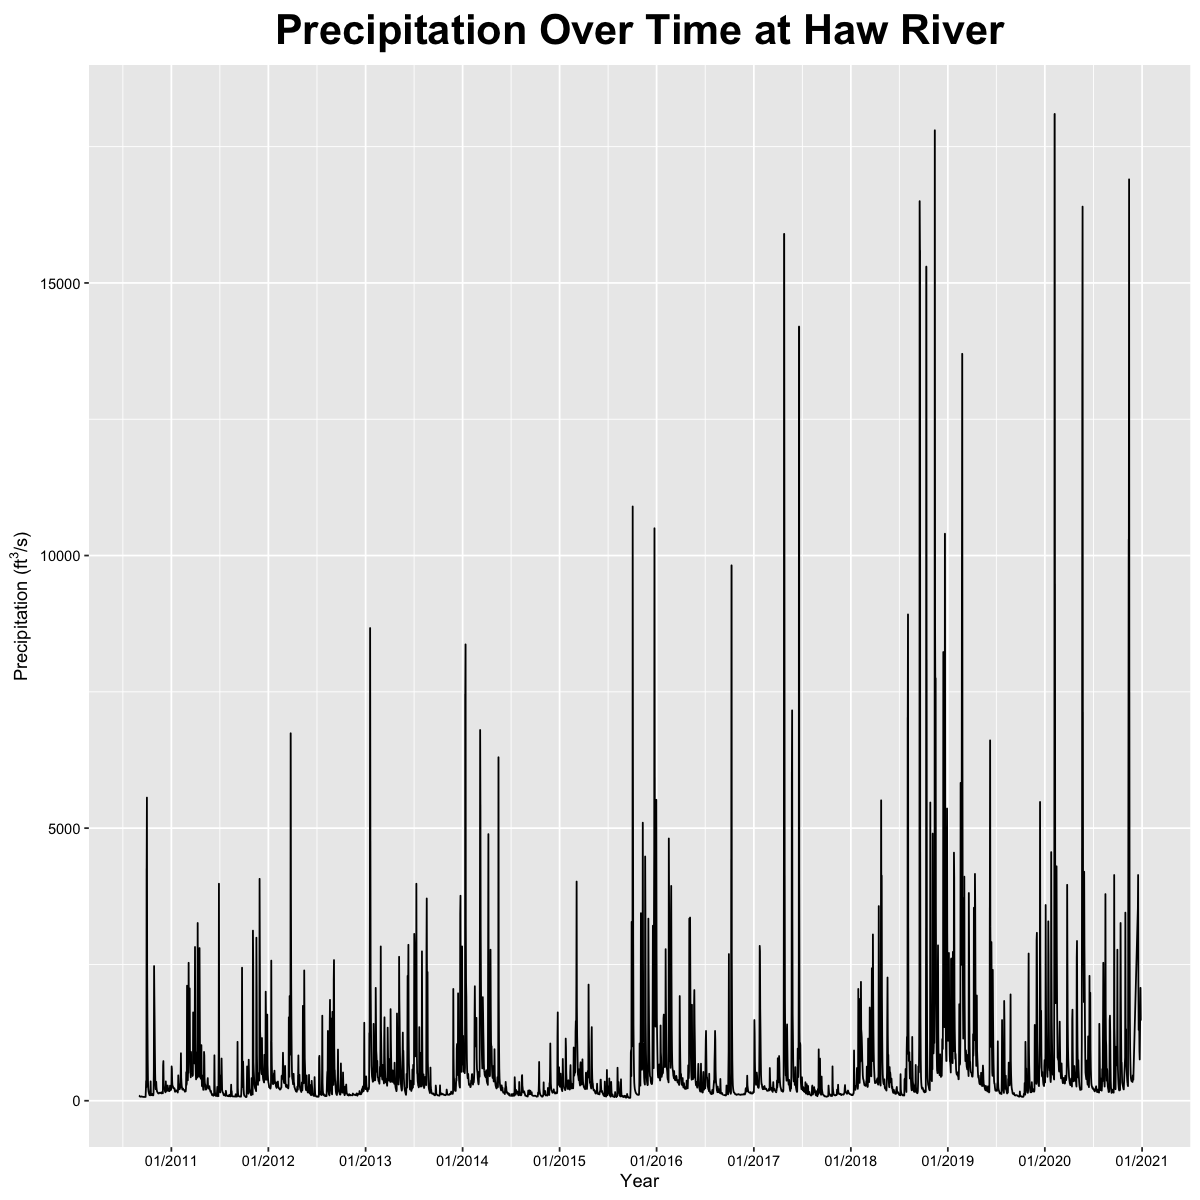

In [44]:
HawPlot <- 
  ggplot(CombinedDischarge, aes(x = Date, y = Haw.Discharge)) +
  geom_line() +
ggtitle("Precipitation Over Time at Haw River") +
  
  labs(x = "Year", y = expression("Precipitation (ft"^3*"/s)")) +
  theme(plot.title = element_text(margin = margin(b = 10), size = 25, hjust=0.5, vjust=0.5, face='bold'), axis.text.x = element_text(color = "black"), axis.text.y = element_text(color = "black")) + 
 scale_x_date(breaks=scales::breaks_width("1 years"), date_labels = "%m/%Y")

print(HawPlot)

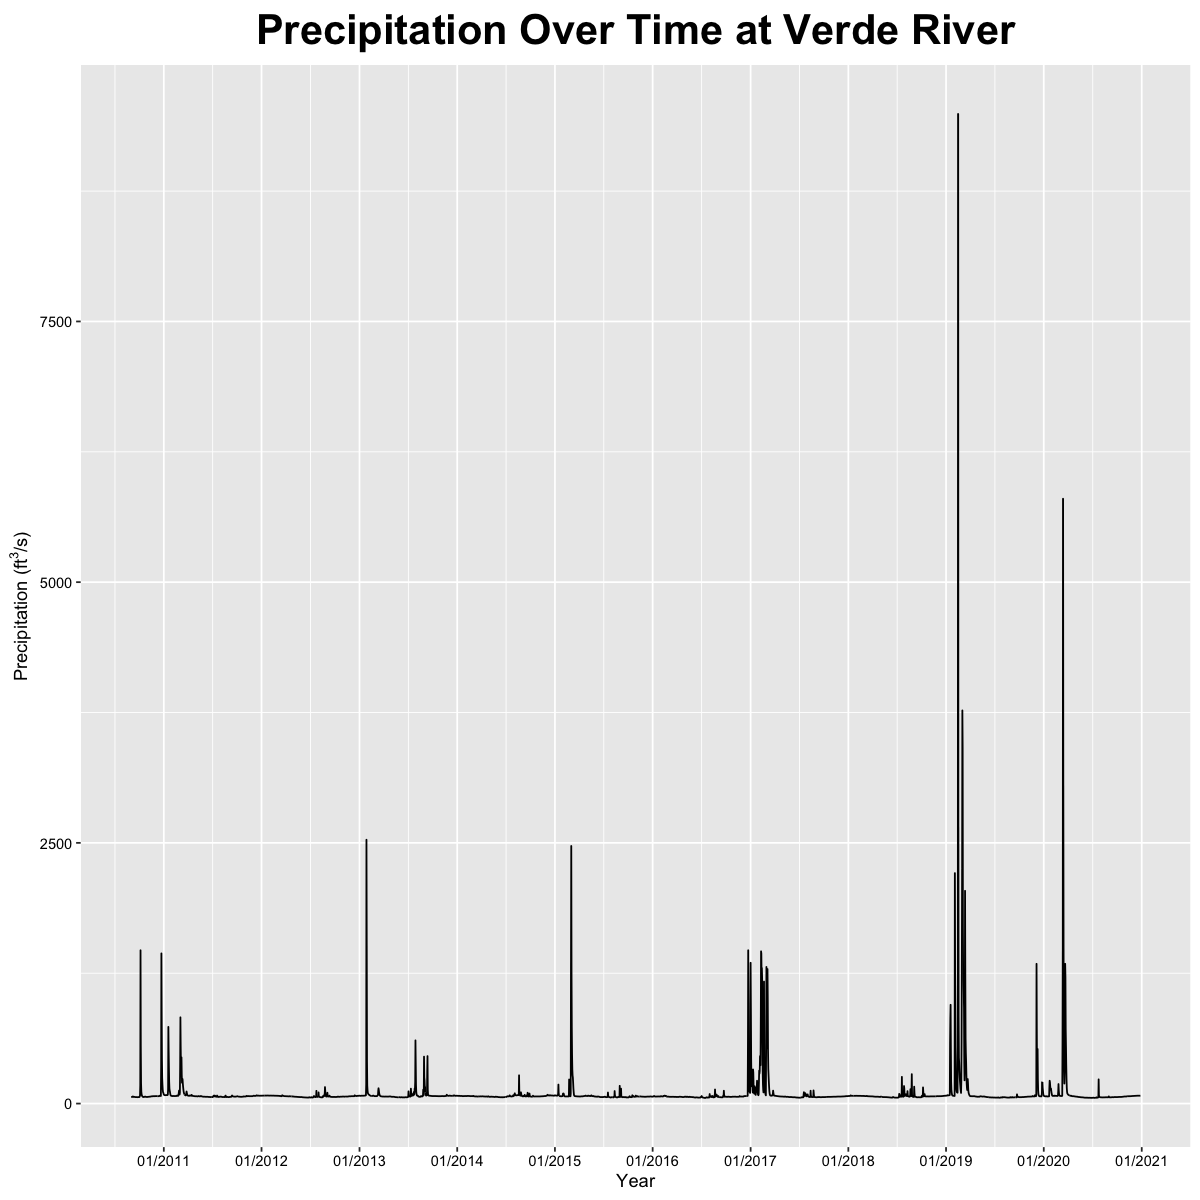

In [45]:
VerdePlot <- 
  ggplot(CombinedDischarge, aes(x = Date, y = Verde.Discharge)) +
  geom_line() +
ggtitle("Precipitation Over Time at Verde River") +
  
  labs(x = "Year", y = expression("Precipitation (ft"^3*"/s)")) +
  theme(plot.title = element_text(margin = margin(b = 10), size = 25, hjust=0.5, vjust=0.5, face='bold'),axis.text.x = element_text(color = "black"), axis.text.y = element_text(color = "black")) + 
 scale_x_date(breaks=scales::breaks_width("1 years"), date_labels = "%m/%Y")

print(VerdePlot)

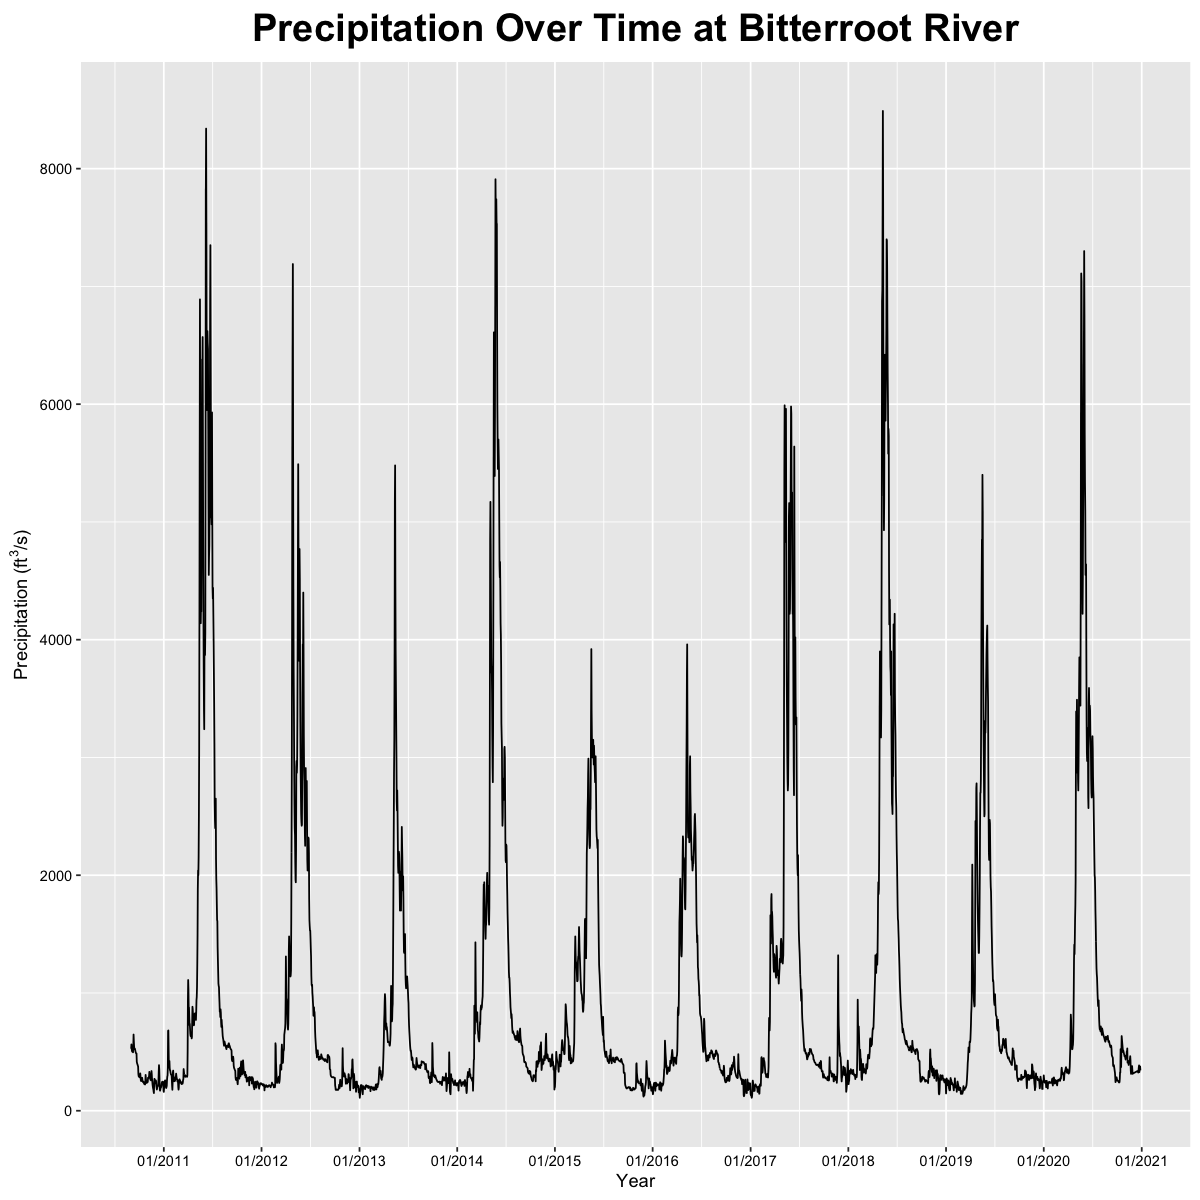

In [46]:
BitterrootPlot <- 
  ggplot(CombinedDischarge, aes(x = Date, y = Bitterroot.Discharge)) +
  geom_line() +
ggtitle("Precipitation Over Time at Bitterroot River") +
  
  labs(x = "Year", y = expression("Precipitation (ft"^3*"/s)")) +
  theme(plot.title = element_text(margin = margin(b = 10), size = 23, hjust=0.5, vjust=0.5, face='bold'),axis.text.x = element_text(color = "black"), axis.text.y = element_text(color = "black")) + 
 scale_x_date(breaks=scales::breaks_width("1 years"), date_labels = "%m/%Y")

print(BitterrootPlot)

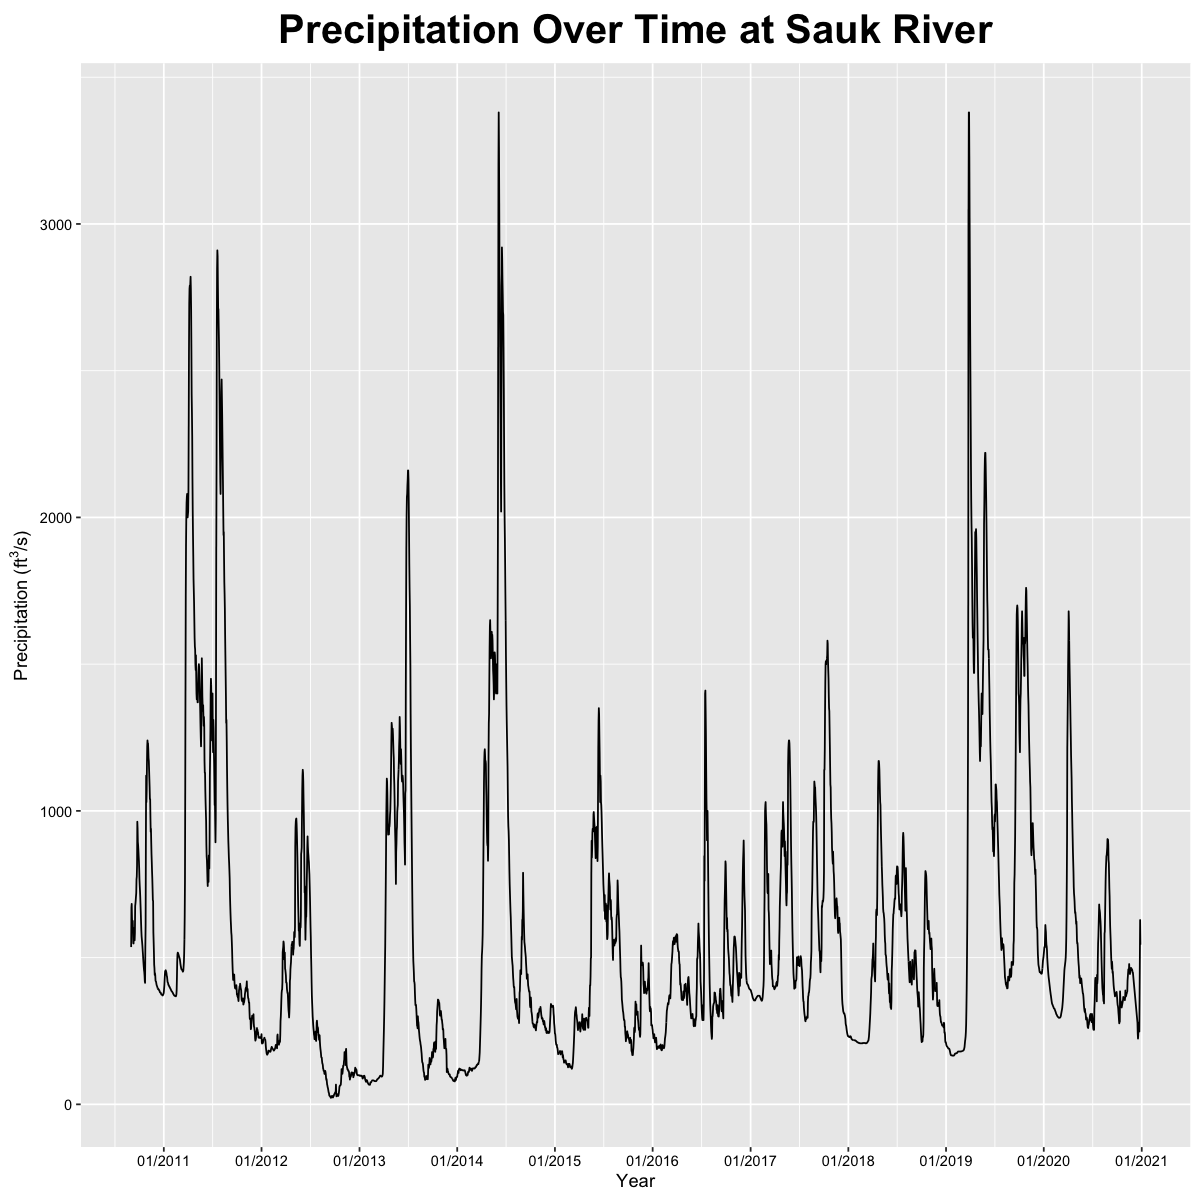

In [47]:
SaukPlot <- 
  ggplot(CombinedDischarge, aes(x = Date, y = Sauk.Discharge)) +
  geom_line() +
ggtitle("Precipitation Over Time at Sauk River") +
  
  labs(x = "Year", y = expression("Precipitation (ft"^3*"/s)")) +
  theme(plot.title = element_text(margin = margin(b = 10), size = 24, hjust=0.5, vjust=0.5, face='bold'),axis.text.x = element_text(color = "Black"), axis.text.y = element_text(color = "Black")) + 
 scale_x_date(breaks=scales::breaks_width("1 years"), date_labels = "%m/%Y")

print(SaukPlot)

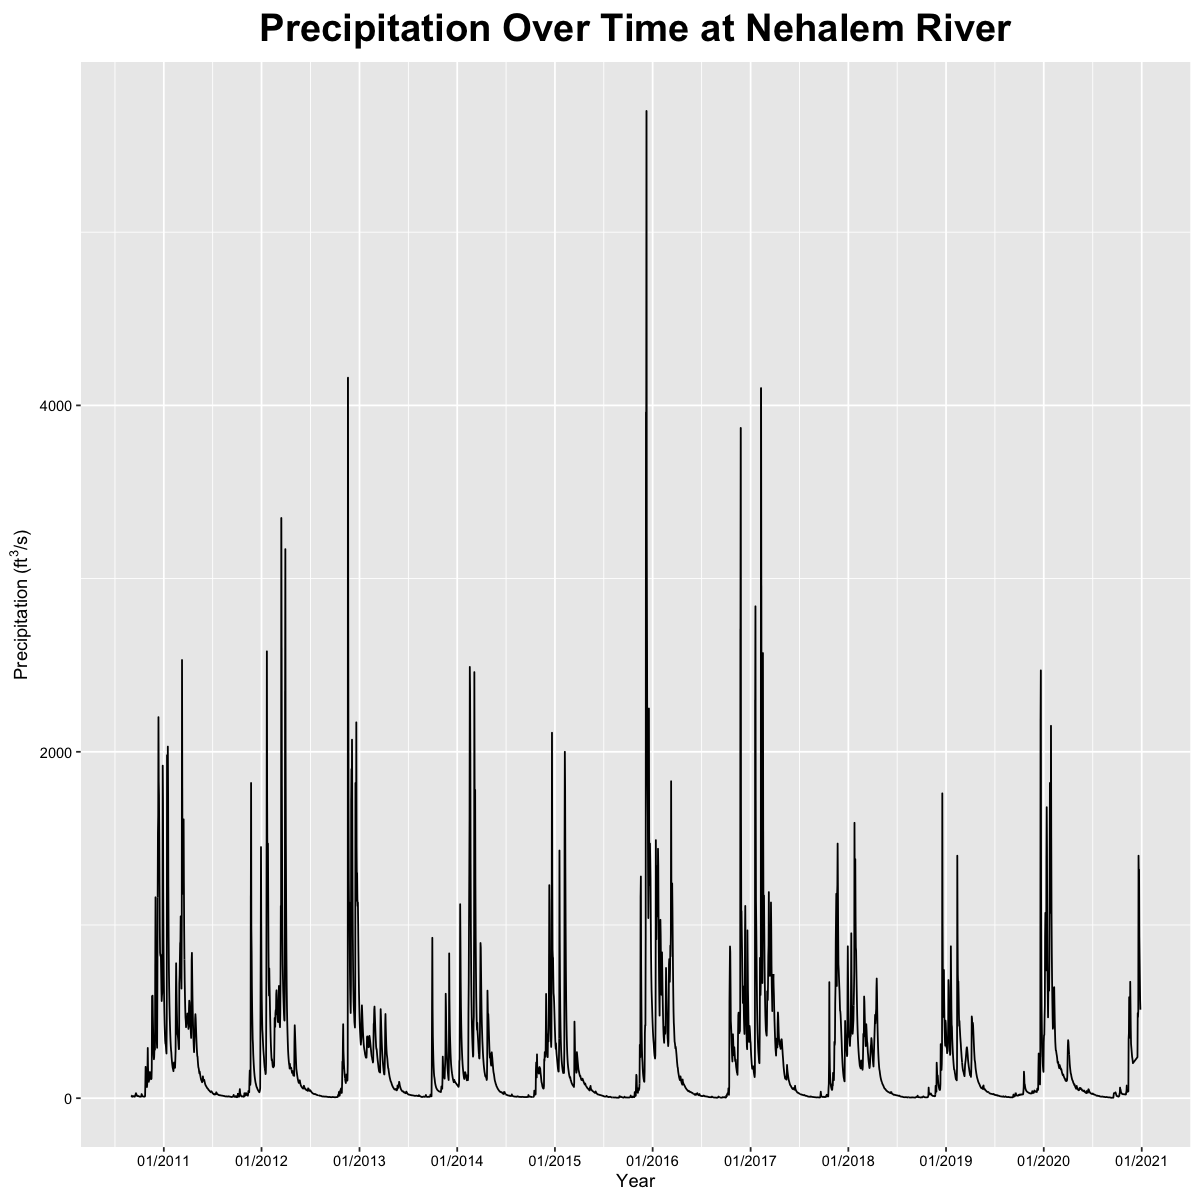

In [48]:
NehalemPlot <- 
  ggplot(CombinedDischarge, aes(x = Date, y = Nehalem.Discharge)) +
  geom_line() +
ggtitle("Precipitation Over Time at Nehalem River") +
  
  labs(x = "Year", y = expression("Precipitation (ft"^3*"/s)")) +
  theme(plot.title = element_text(margin = margin(b = 10), size = 23, hjust=0.5, vjust=0.5, face='bold'),axis.text.x = element_text(color = "Black"), axis.text.y = element_text(color = "Black")) + 
 scale_x_date(breaks=scales::breaks_width("1 years"), date_labels = "%m/%Y")

print(NehalemPlot)

## Combine all Precipitation Plots

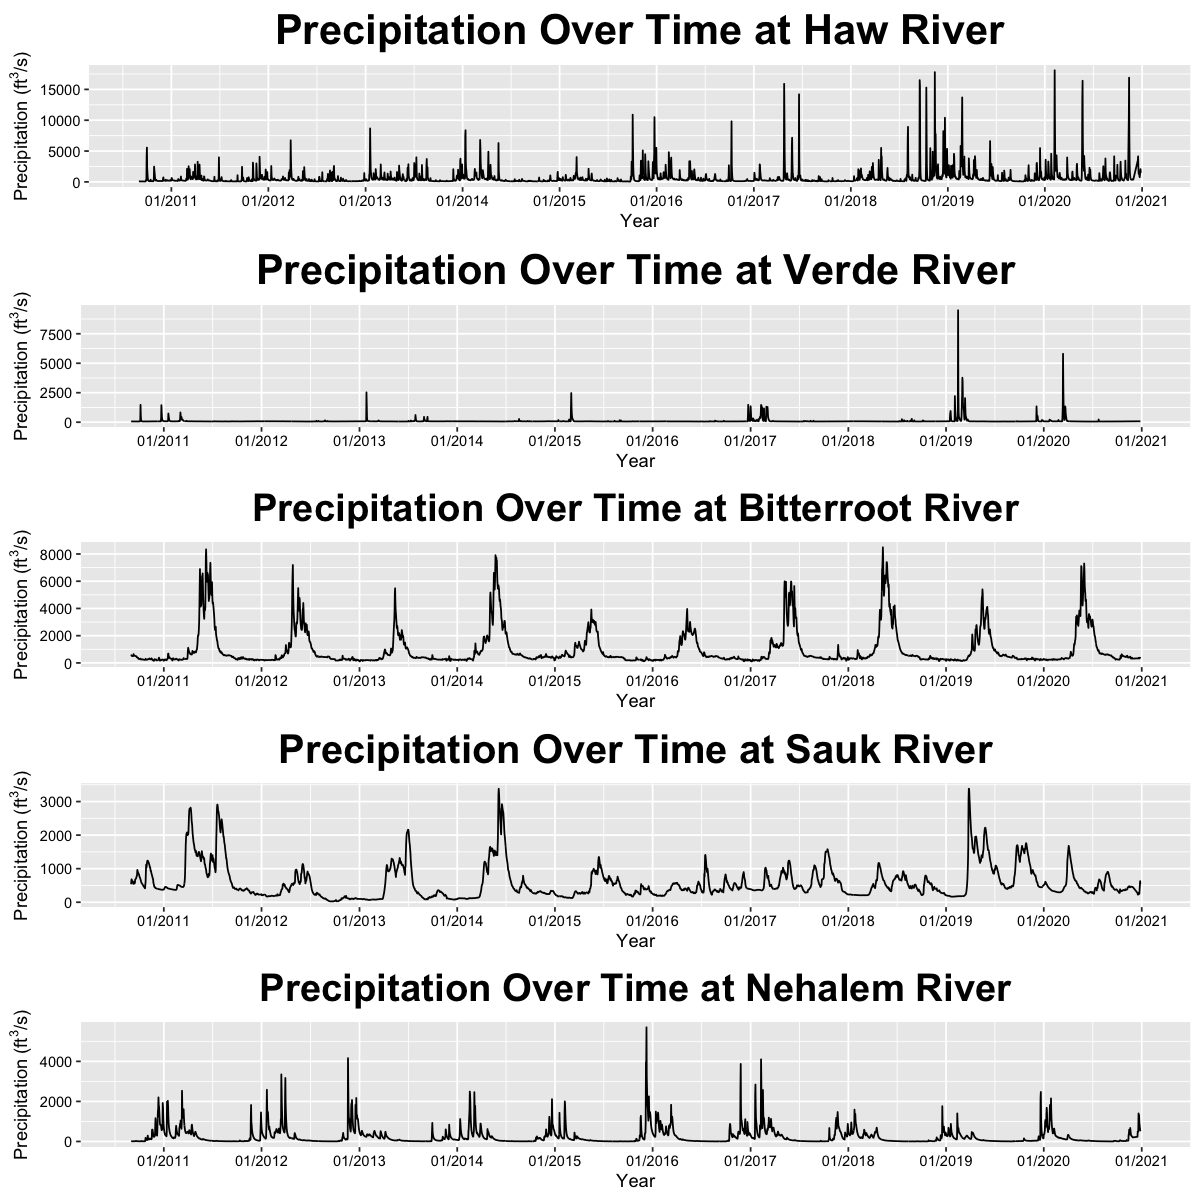

In [49]:
CombinedPlot <- 
  plot_grid(HawPlot, VerdePlot, BitterrootPlot, SaukPlot, NehalemPlot, 
            ncol = 1) 
options(repr.plot.width=10, repr.plot.height=10)
print(CombinedPlot)

### Closing Questions

How does the magnitude of discharge compare for these rivers?

>

Which of these rivers have a seasonal cycle of discharge? How might you explain the presence and timing of seasonal cycles based on climatic conditions?
>

Hypothetical question: If you wanted to create a ggplot using facets instead of `plot_grid`, how would you go about wrangling your dataset differently? 
>